In [1]:
library(rstatix)
library(readr)
# library(lme4)
library(afex)
library(performance)
library(RCurl)
library(optimx)
library(parallel)
library(minqa)
library(ggpubr)
library(ez) 
# https://github.com/mike-lawrence/ez

Warning message:
“package ‘rstatix’ was built under R version 4.0.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter


Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘afex’ was built under R version 4.0.5”
Loading required package: lme4

Warning message:
“package ‘lme4’ was built under R version 4.0.5”
Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.0.5”
************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: emmeans() for ANOVA models now uses model = 'multivariate' as default.
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()


# Forced-choice survey LMER

In [2]:
df = read_csv("../clean_data/forced_choice_emotion_uw_students_long_format_lmer.csv")


── Column specification ──────────────────────────────────────────────────────────────────────────────────────
cols(
  participantId = col_double(),
  photoId = col_character(),
  emotion = col_character(),
  ethnicity = col_character(),
  sex = col_character(),
  age = col_character(),
  label = col_character(),
  url = col_character(),
  sentimentScore = col_double(),
  sexC = col_double(),
  ageC = col_double(),
  ethnicityC = col_double()
)




## Useful links about fitting LMER 
- https://bbolker.github.io/mixedmodels-misc/glmmFAQ.html#singular-models-random-effect-variances-estimated-as-zero-or-correlations-estimated-as---1
- https://stats.stackexchange.com/questions/242109/model-failed-to-converge-warning-in-lmer
- https://easystats.github.io/blog/posts/performance_check_collinearity/
- https://stats.stackexchange.com/questions/449042/is-a-singular-fit-with-no-correlations-near-1-or-variances-of-zero-a-false
- http://svmiller.com/blog/2018/06/mixed-effects-models-optimizer-checks/
- https://joshua-nugent.github.io/allFit/
- https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
- https://stats.stackexchange.com/questions/323273/what-to-do-with-random-effects-correlation-that-equals-1-or-1
- https://psych.wisc.edu/Brauer/BrauerLab/wp-content/uploads/2014/04/Brauer-and-Curtin-in-press-Psych-Methods.pdf
- https://cran.r-project.org/web/packages/lme4/vignettes/lmerperf.html
- https://rpubs.com/palday/lme4-singular-convergence

## Run model with Nelder-Mead opt

**Determining random effect structure**

**Random Intercept**:
- participantId: repeated measures from same participant
- photoId: repeated measures from same photo

**Random slope**:
- ethnicity: varies *within participantId* and *between items*
- sex: varies *within participantId* and *between items*
- age: varies *within participantId* and *between items*

----
- Random intercept and slope for participantId
- Random intercept for photoId

----

In [3]:
# ---------
# doesn't converge
# ---------

# lmer_fc_uw_max = lmer(
#     sentimentScore ~ 1 + sexC*ethnicityC*ageC + (1 + sexC*ethnicityC*ageC|participantId) + (1 | photoId), 
#     data = df, 
#     REML = FALSE, 
#     control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
# )
# summary(lmer_fc_uw_max)

In [4]:
# -------------
# lacks power because there is only 1 obs per cell of [participantId X photoId]
# -------------

lmer_fc_uw_full = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId) + (1 | photoId), 
    data = df, 
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fc_uw_full)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId) + (1 | photoId)
   Data: df
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  2049.7   2164.7  -1008.9   2017.7     9776 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1517 -0.4843  0.0146  0.4421  4.5059 

Random effects:
 Groups        Name            Variance  Std.Dev. Corr             
 photoId       (Intercept)     1.034e-01 0.321522                  
 participantId (Intercept)     1.080e-03 0.032865                  
               sexC            9.943e-06 0.003153 -0.36            
               ethnicityC      2.270e-05 0.004765 -0.21  0.59      
               sexC:ethnicityC 1.161e-03 0.034069  0.07 -0.95 -0.49
 Residual                      6.545e-02 0.255828                  
Number of obs: 97

In [5]:
# --------------
# it doesn't address photoId random effect, but it has better power 20+ obs per cell (i.e., participantId )
# --------------

lmer_fc_uw_partial = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), 
    data = df, REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fc_uw_partial)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: sentimentScore ~ 1 + sexC * ethnicityC + (1 + sexC * ethnicityC |  
    participantId)
   Data: df
Control: lmerControl(optimizer = "Nelder_Mead", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
 10453.6  10561.5  -5211.8  10423.6     9777 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2719 -0.9327  0.1997  0.9007  1.7652 

Random effects:
 Groups        Name            Variance  Std.Dev.  Corr             
 participantId (Intercept)     5.006e-04 0.0223734                  
               sexC            1.391e-06 0.0011792 -1.00            
               ethnicityC      7.550e-07 0.0008689 -0.99  0.99      
               sexC:ethnicityC 6.703e-06 0.0025890  0.86 -0.86 -0.84
 Residual                      1.694e-01 0.4115362                  
Number of obs: 9792, groups:  participantId, 51

Fixed effects:
                  Estimate Std.

## Check collinearity

In [6]:
# check_collinearity(lmer_fc_uw_full)

In [7]:
check_collinearity(lmer_fc_uw_partial)

,Term,VIF,SE_factor
,<chr>,<dbl>,<dbl>
1,sexC,1,1
2,ethnicityC,1,1
3,sexC:ethnicityC,1,1


In [8]:
# plot(check_collinearity(lmer_fc_uw_full))

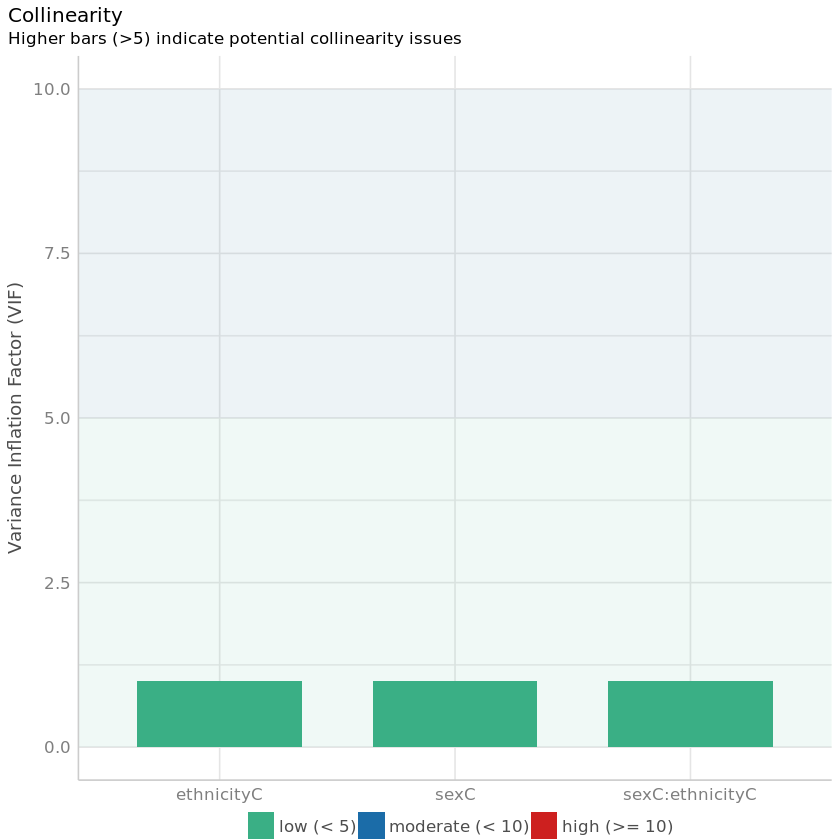

In [9]:
plot(check_collinearity(lmer_fc_uw_partial))

## Check singularity

In [10]:
# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html

# tt = getME(lmer_fc_uw_full,"theta")
# ll = getME(lmer_fc_uw_full,"lower")
# tt_value = min(tt[ll==0])

# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
tt_p = getME(lmer_fc_uw_partial,"theta")
ll_p = getME(lmer_fc_uw_partial,"lower")
tt_value_p = min(tt_p[ll_p==0])

tt_value_p

[1] 0.000128365

In [11]:
tt_value_p < 0.000001
# probably not a problem

[1] FALSE

In [12]:
theta_p <- getME(lmer_fc_uw_partial,"theta")
## diagonal elements are identifiable because they are fitted
##  with a lower bound of zero ...
diag.element <- getME(lmer_fc_uw_partial,"lower")==0
any(theta_p[diag.element]<1e-5)

# probably not a problem

[1] FALSE

## Testing multiple optimizers


In [13]:
# lmer_fc_uw_m = lmer(sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId), data = df)

In [14]:
# ncores <- detectCores()
# diff_optims <- allFit(lmer_fc_uw_m, maxfun = 1e5, parallel = 'multicore', ncpus = ncores)

In [15]:
# is.OK <- sapply(diff_optims, is, "merMod")
# diff_optims.OK <- diff_optims[is.OK]
# lapply(diff_optims.OK,function(x) x@optinfo$conv$lme4$messages)

In [16]:
# (lliks <- sort(sapply(diff_optims.OK,logLik)))

## Three-way Anova 

### Useful links about fitting ANOVAS
- https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/
- https://cran.r-project.org/web/packages/effectsize/vignettes/anovaES.html
- https://rpkgs.datanovia.com/rstatix/reference/anova_test.html
- https://stats.stackexchange.com/questions/11079/problem-with-anova-repeated-measures-error-model-is-singular

### Descriptives

In [17]:
df %>%
  group_by(ethnicity, sex, age) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicity,sex,age,variable,n,mean,sd
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,1224,-0.134,0.417
bipoc,female,child,sentimentScore,1224,-0.089,0.418
bipoc,male,adult,sentimentScore,1224,-0.175,0.406
bipoc,male,child,sentimentScore,1224,-0.121,0.416
white,female,adult,sentimentScore,1224,-0.118,0.410
white,female,child,sentimentScore,1224,-0.089,0.412
white,male,adult,sentimentScore,1224,-0.094,0.395
white,male,child,sentimentScore,1224,-0.104,0.420


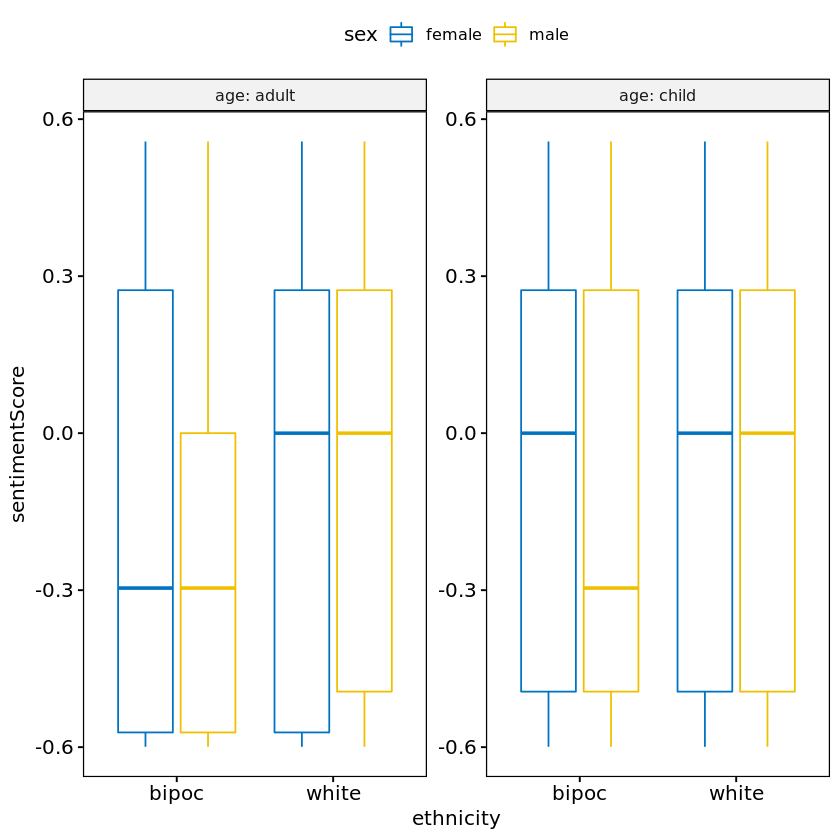

In [18]:
bxp <- ggboxplot(
  df, x = "ethnicity", y = "sentimentScore",
  color = "sex", palette = "jco",
  facet.by = "age", short.panel.labs = FALSE,
  scales = "free"
  )
bxp

### Check assumptions

#### Outliers

In [19]:
df %>% group_by(ethnicity, sex, age) %>% identify_outliers(sentimentScore)

# no outliers

ethnicity,sex,age,participantId,photoId,emotion,label,url,sentimentScore,sexC,ageC,ethnicityC,is.outlier,is.extreme
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>


#### Normality assumption

In [20]:
# Compute Shapiro-Wilk test for each combinations of factor levels

df %>%
  group_by(ethnicity, sex, age) %>%
  shapiro_test(sentimentScore)

ethnicity,sex,age,variable,statistic,p
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bipoc,female,adult,sentimentScore,0.8573349,6.875608e-32
bipoc,female,child,sentimentScore,0.8650087,3.461563e-31
bipoc,male,adult,sentimentScore,0.8444974,5.333350e-33
bipoc,male,child,sentimentScore,0.8590749,9.858681e-32
white,female,adult,sentimentScore,0.8656738,3.995529e-31
white,female,child,sentimentScore,0.8739884,2.521951e-30
white,male,adult,sentimentScore,0.8864712,4.836086e-29
white,male,child,sentimentScore,0.8626490,2.089945e-31


In [21]:
3.461563e-31 < 0.05

# not normal

[1] TRUE

#### QQ plot 

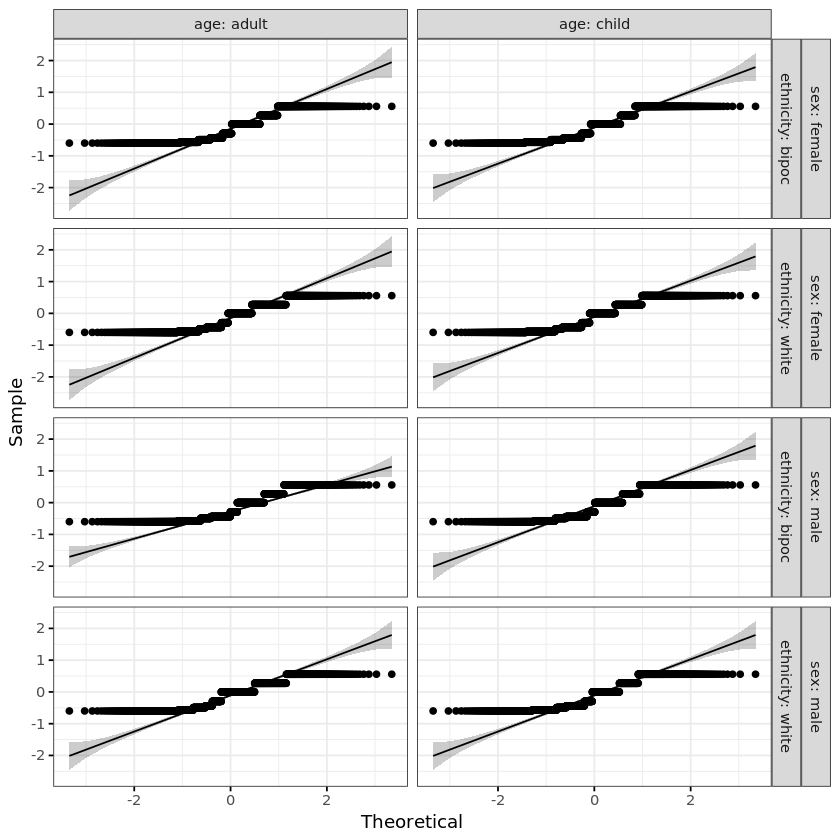

In [22]:
ggqqplot(df, "sentimentScore", ggtheme = theme_bw()) +
  facet_grid(sex + ethnicity ~ age, labeller = "label_both")

**Definetively not normal data**

## Anova 2x2x2 computation 


My design is 2x2x2 fully-crosses, meaning will yield a singular decomposition. 
This is probably why LMER doesn't converge regardless of the optimizer and other hyper-params

Guide: https://www.datanovia.com/en/lessons/repeated-measures-anova-in-r/#summary-statistics-2

In [23]:
df_long = df %>% select(participantId, sex, age, ethnicity, sentimentScore)

In [24]:
df_long = df_long %>% convert_as_factor(participantId, sex, age, ethnicity)

In [25]:
head(df_long)

participantId,sex,age,ethnicity,sentimentScore
<fct>,<fct>,<fct>,<fct>,<dbl>
0,female,adult,bipoc,0.0000
0,male,child,white,0.5574
0,male,adult,bipoc,-0.5994
0,male,child,bipoc,-0.5994
0,male,adult,white,0.5574
0,female,adult,white,-0.2960


In [26]:
# res.aov <- anova_test(
#   data = df_long, dv = sentimentScore, wid = participantId,
#   within = c(sex, age, ethnicity)
#   )
# get_anova_table(res.aov)

In [27]:
res.aov  = ezANOVA(data=df, wid=.(participantId), dv=.(sentimentScore), within=.(sex, age, ethnicity))
res.aov  

Warning message:
“Converting "participantId" to factor for ANOVA.”
Warning message:
“Converting "sex" to factor for ANOVA.”
Warning message:
“Converting "age" to factor for ANOVA.”
Warning message:
“Converting "ethnicity" to factor for ANOVA.”
Warning message:
“Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.”


,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2,sex,1,50,9.521419,3.306335e-03,*,0.016548360
3,age,1,50,21.604378,2.475379e-05,*,0.054099828
4,ethnicity,1,50,31.530648,8.618142e-07,*,0.051307750
5,sex:age,1,50,2.852944,9.743446e-02,,0.003967705
6,sex:ethnicity,1,50,13.324762,6.258531e-04,*,0.026661649
7,age:ethnicity,1,50,19.737606,4.929783e-05,*,0.025649119
8,sex:age:ethnicity,1,50,5.194152,2.696674e-02,*,0.009402510


In [28]:
format(2.696674e-02, scientific=FALSE)

[1] "0.02696674"

There is a statistically significant three-way interactions between age, sex, and ethnicity, Anova, $F$(1, 50) = 5.19, $p$ = 0.03, $\eta^2_{g}=0.009$

### Post-hoc tests

multiple pairwise paired t-tests between the levels of the within-subjects factor

In [29]:
# Pairwise comparisons
pwc <- df %>%
  group_by(age, sex) %>%
  pairwise_t_test(sentimentScore ~ ethnicity, paired = TRUE, p.adjust.method = "bonferroni") %>%
  select(-df, -statistic) # Remove details

pwc

sex,age,.y.,group1,group2,n1,n2,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
female,adult,sentimentScore,bipoc,white,1224,1224,3.34e-01,3.34e-01,ns
male,adult,sentimentScore,bipoc,white,1224,1224,8.88e-07,8.88e-07,****
female,child,sentimentScore,bipoc,white,1224,1224,9.87e-01,9.87e-01,ns
male,child,sentimentScore,bipoc,white,1224,1224,2.97e-01,2.97e-01,ns


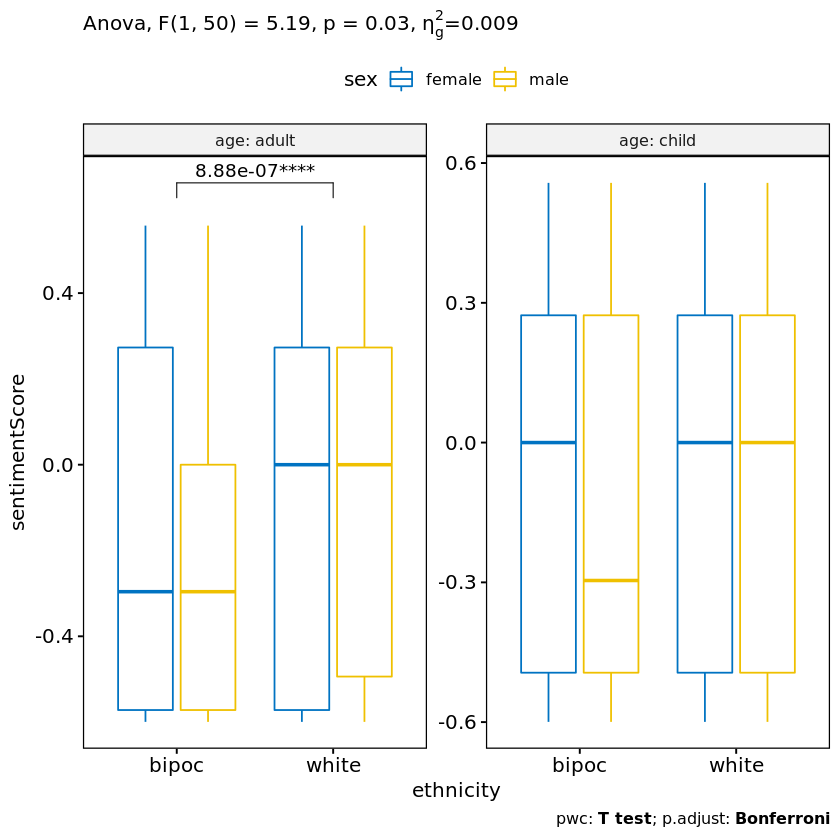

In [30]:
# Visualization: box plots with p-values
# subtitle_3way_anova = "Anova, $F$(1, 50) = 5.19, $p$ = 0.03, $\\eta^2_{g}=0.009$"
subtitle_3way_anova = expression(paste("Anova, F(1, 50) = 5.19, p = 0.03, ",eta[g]^2, "=0.009"))
pwc <- pwc %>% add_xy_position(x = "ethnicity")

bxp +  
  stat_pvalue_manual(
    pwc, hide.ns = TRUE, bracket.nudge.y = 0.1,
    label = "{p.adj}{p.adj.signif}"
    ) +
  labs(
    subtitle = subtitle_3way_anova,
    caption = get_pwc_label(pwc)
  )

In [31]:
ggsave("../clean_data/anova_3way_test_forced_choice.png")
ggsave("../../emotions_dashboard/data/anova_3way_test_forced_choice.png")

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



## Report

-------------------




***PENDING...***



-------------------

## Anova agrgegated across ethnicity for between-effect

In [32]:
mDf = aggregate(sentimentScore ~ participantId + ethnicityC, data=df, FUN=mean)

In [33]:
summary(aov(sentimentScore ~ ethnicityC, data=mDf))     # ANOVA with just the between-effect

             Df  Sum Sq  Mean Sq F value   Pr(>F)    
ethnicityC    1 0.02102 0.021020   12.05 0.000764 ***
Residuals   100 0.17436 0.001744                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [34]:
# Images depicting caucasian faces 

In [35]:
mDf %>%
  group_by(ethnicityC) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

ethnicityC,variable,n,mean,sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-0.5,sentimentScore,51,-0.130,0.042
0.5,sentimentScore,51,-0.101,0.041


In [36]:
-0.130 - (-0.101)

[1] -0.029

# Free-labeling

In [37]:
df_free = read_csv("../clean_data/free_labeling_emotion_uw_students_long_format_lmer.csv")


── Column specification ──────────────────────────────────────────────────────────────────────────────────────
cols(
  participantId = col_double(),
  photoId = col_character(),
  emotion = col_character(),
  ethnicity = col_character(),
  sex = col_character(),
  age = col_character(),
  label = col_character(),
  url = col_character(),
  sentimentScore = col_double(),
  sexC = col_double(),
  ageC = col_double(),
  ethnicityC = col_double()
)




In [38]:
df_free

participantId,photoId,emotion,ethnicity,sex,age,label,url,sentimentScore,sexC,ageC,ethnicityC
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,Q2.1_1,angry,bipoc,female,adult,anger,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bJXdODAZHOaG0rI,-0.5106,-0.5,0.5,-0.5
0,Q102.1_1,bored,bipoc,male,child,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bw2zfW24xOcYU9o,-0.2732,0.5,-0.5,-0.5
0,Q103.1_1,bored,white,female,adult,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_bqKH78xvssoHVoG,-0.2732,-0.5,0.5,0.5
0,Q194.1_1,funny,white,male,adult,uncertain,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_8oGUDKsFJy6Upeu,0.4404,0.5,0.5,0.5
0,Q104.1_1,scared,white,female,child,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_7WGuIqyEG3TilMi,-0.4404,-0.5,-0.5,0.5
0,Q101.1_1,sad,bipoc,male,adult,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_3gSfRO9Zt2G8NP8,-0.4767,0.5,0.5,-0.5
0,Q97.1_2,happy,white,male,adult,happiness,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_ewCuSR8n6UYi2MK,0.5719,0.5,0.5,0.5
0,Q98.1_1,happy,white,male,child,happiness,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_2hrynYgwGLMuDUG,0.5719,0.5,-0.5,0.5
0,Q100.1_1,sad,bipoc,female,child,neutral,https://uwmadison.co1.qualtrics.com/ControlPanel/Graphic.php?IM=IM_5bFJqMaV53Zsy0K,-0.4767,-0.5,-0.5,-0.5


## Run model with Nelder-Mead opt

**Determining random effect structure**

**Random Intercept**:
- participantId: repeated measures from same participant
- photoId: repeated measures from same photo

**Random slope**:
- ethnicity: varies *within participantId* and *between items*
- sex: varies *within participantId* and *between items*
- age: varies *within participantId* and *between items*

----
- Random intercept and slope for participantId
- Random intercept for photoId

----

In [ ]:
# -------------
# lacks power because there is only 1 obs per cell of [participantId X photoId]
# -------------

lmer_fl_uw_full = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC|participantId) + (1 | photoId), 
    data = df_free,
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fl_uw_full)

In [ ]:
# --------------
# it doesn't address photoId random effect, but it has better power 20+ obs per cell (i.e., participantId )
# Also, I specified multiple uncorrelated random effects for the same grouping variable, so the model converge
# --------------

lmer_fl_uw_partial = lmer(
    sentimentScore ~ 1 + sexC*ethnicityC + (1 + sexC*ethnicityC||participantId), 
    data = df_free, 
    REML = FALSE, 
    control = lmerControl(optimizer ="Nelder_Mead", calc.derivs=FALSE)
)
summary(lmer_fl_uw_partial)

## Check collinearity

In [ ]:
check_collinearity(lmer_fl_uw_partial)

In [ ]:
plot(check_collinearity(lmer_fl_uw_partial))

## Check singularity

In [ ]:
check_collinearity(lmer_fl_uw_partial)

In [ ]:
# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html


# https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html
tt_p = getME(lmer_fl_uw_partial,"theta")
ll_p = getME(lmer_fl_uw_partial,"lower")
tt_value_p = min(tt_p[ll_p==0])

tt_value_p

In [ ]:
theta_p <- getME(lmer_fl_uw_partial,"theta")
## diagonal elements are identifiable because they are fitted
##  with a lower bound of zero ...
diag.element <- getME(lmer_fl_uw_partial,"lower")==0
any(theta_p[diag.element]<1e-5)

# there may be a problem

## Three-way Anova 

In [ ]:
df_free %>%
  group_by(ethnicity, sex, age) %>%
  get_summary_stats(sentimentScore, type = "mean_sd")

In [ ]:
bxp_free <- ggboxplot(
  df_free, x = "ethnicity", y = "sentimentScore",
  color = "sex", palette = "jco",
  facet.by = "age", short.panel.labs = FALSE
  )
bxp_free

### Check assumptions

#### Outliers

In [ ]:
df_free %>% group_by(ethnicity, sex, age) %>% identify_outliers(sentimentScore)
# just one not-extreme outlier

#### Normality assumption

In [ ]:
# Compute Shapiro-Wilk test for each combinations of factor levels

df_free %>%
  group_by(ethnicity, sex, age) %>%
  shapiro_test(sentimentScore)

#### QQ plot 

In [ ]:
ggqqplot(df_free, "sentimentScore", ggtheme = theme_bw()) +
  facet_grid(sex + ethnicity ~ age, labeller = "label_both")

**Not normally distributed**

## Anova 2x2x2 computation 


In [ ]:
df_long_free = df_free %>% select(participantId, sex, age, ethnicity, sentimentScore)
df_long_free = df_long_free %>% convert_as_factor(participantId, sex, age, ethnicity)
head(df_long_free)

In [ ]:
res.aov  = ezANOVA(data=df_long_free, wid=.(participantId), dv=.(sentimentScore), within=.(sex, age, ethnicity))
res.aov  

The three-way interactions between age, sex, and ethnicity, was not significant, Anova, $F$(1, 48) = 0.76, $p$ = 0.3, $\eta^2_{g}=0.001$

## Post-hoc tests

multiple pairwise paired t-tests between the levels of the within-subjects factor

In [ ]:
df_free %>%
  group_by(age, sex)

which(is.na(tmp))

In [ ]:
# Pairwise comparisons
pwc <- df_free %>%
  group_by(age, sex) %>%
  pairwise_t_test(sentimentScore ~ ethnicity, paired = FALSE, p.adjust.method = "bonferroni") 

pwc

In [ ]:
# Visualization: box plots with p-values
# subtitle_3way_anova = Anova, $F$(1, 48) = 0.76, $p$ = 0.3, $\eta^2_{g}=0.001$
subtitle_3way_anova_free = expression(paste("Anova, F(1, 48) = 0.76, p = 0.3, ",eta[g]^2, "=0.001"))
pwc <- pwc %>% add_xy_position(x = "ethnicity")

bxp_free +  
  stat_pvalue_manual(
    pwc, hide.ns = TRUE, bracket.nudge.y = 0.1,
    label = "{p.adj}{p.adj.signif}"
    ) +
  labs(
    subtitle = subtitle_3way_anova_free,
    caption = get_pwc_label(pwc)
  )

In [ ]:
ggsave("../clean_data/anova_3way_test_free_labeling.png")
ggsave("../../emotions_dashboard/data/anova_3way_test_free_labeling.png")